In [738]:
import PyQt5
%matplotlib qt
# %matplotlib inline 
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
import cv2
from scipy.interpolate import interpn
from tqdm.auto import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.transforms as mtransforms

In [5]:
def convert_xyz(img):
    M_RGB_XYZ = np.array([[0.4124564, 0.3575761, 0.1804375],
     [0.2126729, 0.7151522, 0.0721750],
     [0.0193339, 0.1191920, 0.9503041]])
    xyz = np.matmul(img, M_RGB_XYZ)
    lumi_channel = xyz[:, :, 1]
    return lumi_channel

In [41]:
I = []
h = 0
w = 0
for id in range(1, 8, 1):
    img = skimage.io.imread('data/input_{}.tif'.format(id))
    print(img.min(), img.max())
    luminance = convert_xyz(img)
    if id == 1:
        h, w = luminance.shape
    I.append(luminance.flatten())
I = np.stack(I, axis=0)
print(I.shape)

98 39937
0 51956
0 35809
0 44537
0 43840
0 43297
0 42629
(7, 159039)


In [106]:
U, S, Vh = np.linalg.svd(I, full_matrices=False)
S = np.diag(S)
print(U.shape, S.shape, Vh.shape)

(7, 7) (7, 7) (7, 159039)


In [107]:
singular_vals = np.sqrt(S)[:3, :3]
print(singular_vals)

[[4497.97979125    0.            0.        ]
 [   0.         1549.90401541    0.        ]
 [   0.            0.         1295.57224563]]


In [108]:
Le = np.matmul(U[:, :3], singular_vals)
Be = np.matmul(singular_vals, Vh[:3, :])
print(Le.shape, Be.shape)

(7, 3) (3, 159039)


In [93]:
Ae = np.linalg.norm(Be, axis=0)
Ne = Be / Ae
print(Ae.shape, Ne.shape)

(159039,) (3, 159039)


In [94]:
Ae = np.reshape(Ae, (h, w))
Ne = np.reshape(Ne, (3, h, w))
print(f'reshaped albedo {Ae.shape}, reshaped normal map {Ne.shape}')

reshaped albedo (431, 369), reshaped normal map (3, 431, 369)


In [95]:
Ne.min(), Ne.max() # in the range [-1, 1]

(-0.9999994445523214, 0.9814213518282863)

In [96]:
def map_normal(normal_img):
    return (normal_img + 1.0)/2.0

In [97]:
Ne_vis = map_normal(Ne)
Ne_vis = np.transpose(Ne_vis, (1, 2, 0))
Ne_vis.min(), Ne_vis.max() # in the range [-1, 1]

(2.7772383931479183e-07, 0.9907106759141431)

In [98]:
Q = np.array([[4, -5, -2], [5, -6, -2], [-8, 9, 3]])
print(Q.shape, Le.shape, Be.shape)
Lq = np.matmul(Q, Le.T)
Q_inv = np.linalg.inv(Q)
Bq = np.matmul(Q_inv, Be)

# get A, B
Aq = np.linalg.norm(Bq, axis=0)
Nq = Bq / Aq
print(Aq.shape, Nq.shape)

Aq = np.reshape(Aq, (h, w))
Nq = np.reshape(Nq, (3, h, w))
print(f'reshaped albedo {Aq.shape}, reshaped normal map {Nq.shape}')

(3, 3) (7, 3) (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (3, 431, 369)


In [99]:
Nq_vis = map_normal(Nq)
Nq_vis = np.transpose(Nq_vis, (1, 2, 0))
Nq_vis.min(), Nq_vis.max() # in the range [-1, 1]

(0.005826317666254077, 0.999553781535856)

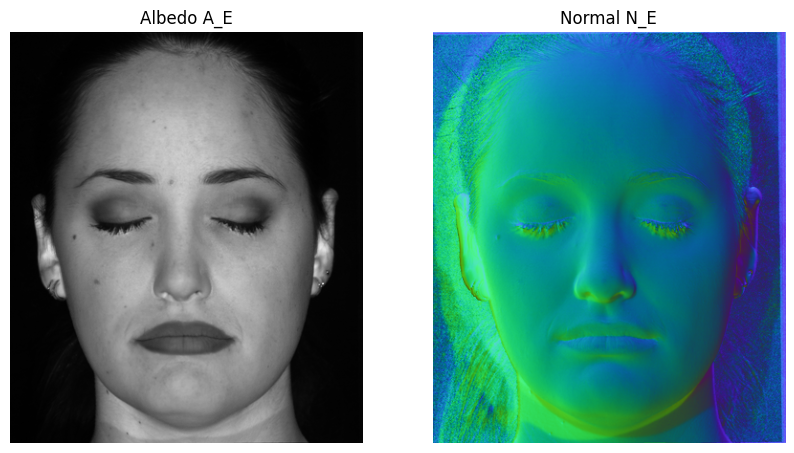

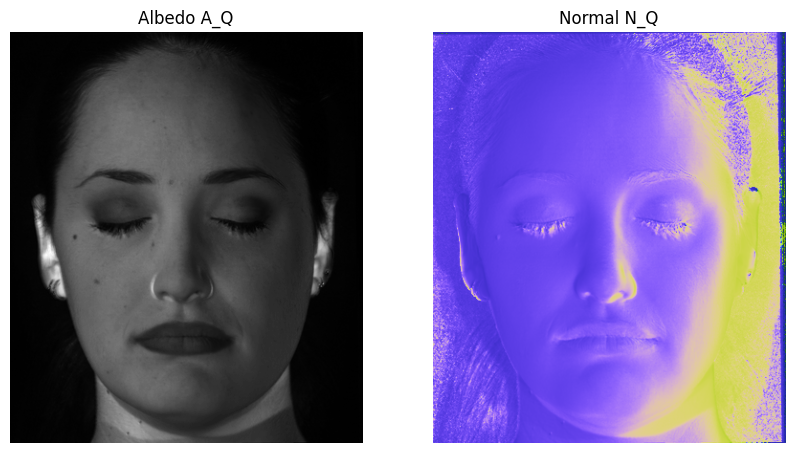

In [100]:
plot_2fig(Ae, Ne_vis, 'sv_e.png', 'Albedo A_E', 'Normal N_E')
plot_2fig(Aq, Nq_vis, 'sv_q.png', 'Albedo A_Q', 'Normal N_Q')

### Enforcing integrability

In [661]:
def decompose_pseudo_normal(B):
    # input shape B: (3, HxW)
    # returns albedo and norm
    print(f'check B {B.shape}')
    A = np.linalg.norm(B, axis=0)
    N = B / A
    print(A.shape, N.shape)

    A = np.reshape(A, (h, w))
    N = np.reshape(N.T, (h, w, 3))
    # N = np.transpose(N, (1, 2, 0))
    print(f'reshaped albedo {A.shape}, reshaped normal map {N.shape}')
    
    N_vis = map_normal(N)
    print(N_vis.min(), N_vis.max())
    
    return A, N_vis

In [750]:
be = np.reshape(np.transpose(Be), (h, w, 3))

# apply blur
sigma = 6.0
be_blur = []
for i in range(3):
    channel_blur = scipy.ndimage.gaussian_filter(be[:, :, i], sigma)
    be_blur.append(channel_blur)
be_blur = np.stack(be_blur, axis=2)
print(be_blur.shape)

# x and y gradients 
dx = np.gradient(be_blur, axis=1)
dy = np.gradient(be_blur, axis=0)
print(dx.shape, dy.shape)

(431, 369, 3)
(431, 369, 3) (431, 369, 3)


In [751]:
be_allpix = np.reshape(be, (-1, 3))
dx_allpix = np.reshape(dx, (-1, 3))
dy_allpix = np.reshape(dy, (-1, 3))
print(be_allpix.shape)
# A
A1 = (be_allpix[:, 0] * dx_allpix[:, 1]) - (be_allpix[:, 1] * dx_allpix[:, 0])
A2 = (be_allpix[:, 0] * dx_allpix[:, 2]) - (be_allpix[:, 2] * dx_allpix[:, 0])
A3 = (be_allpix[:, 1] * dx_allpix[:, 2]) - (be_allpix[:, 2] * dx_allpix[:, 1])
A4 = -(be_allpix[:, 0] * dy_allpix[:, 1]) + (be_allpix[:, 1] * dy_allpix[:, 0])
A5 = -(be_allpix[:, 0] * dy_allpix[:, 2]) + (be_allpix[:, 2] * dy_allpix[:, 0])
A6 = -(be_allpix[:, 1] * dy_allpix[:, 2]) + (be_allpix[:, 2] * dy_allpix[:, 1])

A_mat = np.stack((A1, A2, A3, A4, A5, A6), axis=1)
A_mat.shape

(159039, 3)


(159039, 6)

In [752]:
u, s, vh = np.linalg.svd(A_mat, full_matrices=False)
print(u.shape, vh.shape)
x = vh[-1, :] # null space, last row of vh
print(x)
delta = np.array([[-x[2], x[5], 1], [x[1], -x[4], 0], [-x[0], x[3], 0]])
print(delta)

(159039, 6) (6, 6)
[ 0.1658535  -0.53203342 -0.15793332 -0.74800032 -0.22316359 -0.23491201]
[[ 0.15793332 -0.23491201  1.        ]
 [-0.53203342  0.22316359  0.        ]
 [-0.1658535  -0.74800032  0.        ]]


In [768]:
delta_inv = np.linalg.inv(delta)
print(delta_inv.shape, be.shape)
be_integrate = np.matmul(delta_inv, Be)
print(be_integrate.shape)
# try hint
G_f = np.array([[1, 0, 1], [0, 1, -1], [0, 0, -1]])
G_temp = np.linalg.inv(G_f)
be_integrate_ = np.matmul(G_temp, be_integrate)
A_int, N_int = decompose_pseudo_normal(be_integrate_)

(3, 3) (431, 369, 3)
(3, 159039)
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
0.0012275263556109084 0.9999825015390233


In [769]:
A_int.min(), A_int.max()
# A_int = (A_int - A_int.min()) / (A_int.max() - A_int.min())

(0.2852875384548667, 46.45418398377871)

In [770]:
plot_2fig(A_int, N_int, 'sv_integrability_gbr.png', 'Albedo after integrability, sigma=6.0, u=1, v=2', 'Normal after integrability')

In [771]:
N_int.shape

(431, 369, 3)

In [772]:
eps = 1e-12
zx = N_int[:, :, 0]/(N_int[:, :, 2] + eps)
zy = N_int[:, :, 1]/(N_int[:, :, 2] + eps)

In [773]:
import sys
sys.path.append("/Users/prachigarg/Desktop/assgn5/src") 
from cp_hw5 import integrate_poisson, integrate_frankot, load_sources

In [774]:
Z = integrate_frankot(zx, zy)
Z.min(), Z.max()

(-36.64456414847299, 44.703484381418505)

In [775]:
# Z = integrate_poisson(dx, dy)

In [776]:
def normalize_01(depth):
    return (depth - depth.min()) / (depth.max() - depth.min())

In [777]:
Z = normalize_01(Z)
print(Z.min(), Z.max())
plt.imshow(Z, cmap='gray')
plt.axis('off')
plt.savefig('depth_uncalibrated.png')

0.0 1.0


2023-11-21 22:09:51.979 python[98263:5555989] +[CATransaction synchronize] called within transaction
2023-11-21 22:09:52.132 python[98263:5555989] +[CATransaction synchronize] called within transaction


In [778]:
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
# Z is an HxW array of surface depths
H, W = Z.shape
x, y = np.meshgrid(np.arange(0,W), np.arange(0,H))
# set 3D figure
fig = plt.figure()
ax = fig.gca(projection='3d')
# add a light and shade to the axis for visual effect
# (use the ‘-’ sign since our Z-axis points down)
ls = LightSource()
color_shade = ls.shade(-Z, plt.cm.gray)
# display a surface
# (control surface resolution using rstride and cstride)
surf = ax.plot_surface(x, y, -Z, facecolors=color_shade, rstride=4, cstride=4)
# ax.view_init(elev=10, azim=90)
# turn off axis
plt.axis('off')
plt.show()

2023-11-21 22:10:09.759 python[98263:5555989] +[CATransaction synchronize] called within transaction
2023-11-21 22:10:09.906 python[98263:5555989] +[CATransaction synchronize] called within transaction


### Calibrated

In [740]:
L = load_sources() # A = 7x3
print(f'light matrix \n {L}, {L.shape}')

light matrix 
 [[-0.1418 -0.1804 -0.9267]
 [ 0.1215 -0.2026 -0.9717]
 [-0.069  -0.0345 -0.838 ]
 [ 0.067  -0.0402 -0.9772]
 [-0.1627  0.122  -0.979 ]
 [ 0.      0.1194 -0.9648]
 [ 0.1478  0.1209 -0.9713]], (7, 3)


In [741]:
I.shape # b = 7xN

(7, 159039)

In [742]:
B_calibrated = np.linalg.lstsq(L, I)[0]
B_calibrated.shape

/var/folders/hd/n1h1bh010cv5cm5k41bsp7y00000gp/T/ipykernel_98263/3291473867.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B_calibrated = np.linalg.lstsq(L, I)[0]


(3, 159039)

In [743]:
A_calib, N_calib = decompose_pseudo_normal(B_calibrated)
plot_2fig(A_calib, N_calib, 'sv_calibrated.png', 'Albedo, calibrated', 'Normal, calibrated')

check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.592430933783362e-06 0.993377748794196


In [747]:
eps = 1e-10
zx = N_int[:, :, 0]/(N_int[:, :, 2] + eps)
zy = N_int[:, :, 1]/(N_int[:, :, 2] + eps)

Z = integrate_frankot(zx, zy)
Z.min(), Z.max()

# Z = normalize_01(Z)
print(Z.min(), Z.max())
plt.imshow(Z, cmap='gray')
plt.axis('off')
plt.savefig('depth_calibrated.png')

-43.77616206995299 55.78664561366435


In [748]:
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
# Z is an HxW array of surface depths
H, W = Z.shape
x, y = np.meshgrid(np.arange(0,W), np.arange(0,H))
# set 3D figure
fig = plt.figure()
ax = fig.gca(projection='3d')
# add a light and shade to the axis for visual effect
# (use the ‘-’ sign since our Z-axis points down)
ls = LightSource()
color_shade = ls.shade(-Z, plt.cm.gray)
# display a surface
# (control surface resolution using rstride and cstride)
surf = ax.plot_surface(x, y, -Z, facecolors=color_shade, rstride=4, cstride=4)
# ax.view_init(elev=10, azim=90)
# turn off axis
plt.axis('off')
plt.show()

2023-11-21 22:01:48.587 python[98263:5555989] +[CATransaction synchronize] called within transaction
2023-11-21 22:01:48.758 python[98263:5555989] +[CATransaction synchronize] called within transaction
2023-11-21 22:01:57.443 python[98263:5555989] +[CATransaction synchronize] called within transaction
2023-11-21 22:01:57.574 python[98263:5555989] +[CATransaction synchronize] called within transaction


In [85]:
def plot_2fig(fig1, fig2, name=None, title1=None, title2=None):
    fig = plt.figure(figsize=(10, 6))
    fig.add_subplot(1, 2, 1)
    plt.imshow(fig1, cmap='gray')
    plt.title(title1)
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(fig2, cmap='gray')
    plt.title(title2)
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()
    
def plot_2fig_difference(fig1, fig2, name=None, title1=None, title2=None):
    fig = plt.figure(figsize=(18, 8))
    fig.add_subplot(1, 3, 1)
    plt.imshow(fig1, cmap='gray')
    plt.title(title1)
    plt.axis('off')
    fig.add_subplot(1, 3, 2)
    plt.imshow(fig2, cmap='gray')
    plt.title(title2)
    plt.axis('off')
    
    fig.add_subplot(1, 3, 3)
    plt.imshow(fig1-fig2, cmap='gray')
    plt.title('Difference')
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()
    
def plot_3fig(fig1, fig2, fig3, name=None, t1=None, t2=None, t3=None):
    fig = plt.figure(figsize=(18, 8))
    fig.add_subplot(1, 3, 1)
    plt.imshow(fig1, cmap='gray')
    plt.title(t1)
    plt.axis('off')
    fig.add_subplot(1, 3, 2)
    plt.imshow(fig2, cmap='gray')
    plt.title(t2)
    plt.axis('off')
    fig.add_subplot(1, 3, 3)
    plt.imshow(fig3, cmap='gray')
    plt.title(t3)
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()